In [ ]:
#| default_exp core

# Source

> Source code for fastlite

## Metadata

In [ ]:
#| export
from dataclasses import dataclass, field, make_dataclass, fields, Field, is_dataclass, MISSING
from typing import Any,Union,Optional, get_args
from enum import Enum
from inspect import get_annotations

from fastcore.utils import *
from fastcore.xml import highlight
from fastcore.xtras import hl_md, dataclass_src
from apswutils.db import *
from apswutils.utils import rows_from_file,TypeTracker,Format
from apswutils.db import NotFoundError
import types

try: from graphviz import Source
except ImportError: pass

In [ ]:
from IPython.display import Markdown
from fastcore.test import test_fail, test_eq
from fastcore.net import urlsave
import logging

In [ ]:
#| hide
sys.path.insert(0,'.')

In [ ]:
url = 'https://github.com/lerocha/chinook-database/raw/master/ChinookDatabase/DataSources/Chinook_Sqlite.sqlite'
path = Path('chinook.sqlite')
if not path.exists(): urlsave(url, path)

In [ ]:
logging.getLogger('apsw').setLevel(logging.ERROR)
db = Database("chinook.sqlite")

In [ ]:
#| exports
class _Getter:
    "Abstract class with dynamic attributes providing access to DB objects"
    def __init__(self, db): self.db = db
    # NB: Define `__dir__` in subclass to get list of objects
    def __repr__(self): return ", ".join(dir(self))
    def __contains__(self, s): return (s if isinstance(s,str) else s.name) in dir(self)
    def __iter__(self): return iter(self[dir(self)])
    def __getitem__(self, idxs):
        if isinstance(idxs,str): return self.db.table(idxs)
        return [self.db.table(o) for o in idxs]
    def __getattr__(self, k):
        if k[0]=='_': raise AttributeError
        return self.db[k]

class _TablesGetter(_Getter):
    def __dir__(self): return [o for o in self.db.table_names() if not o.startswith('sqlite_')]

@patch(as_prop=True)
def t(self:Database): return _TablesGetter(self)

By returning a `_TablesGetter` we get a repr and auto-complete that shows all tables in the DB.

In [ ]:
dt = db.t
dt

Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track, pet_food

In [ ]:
artist = dt.Artist
artist

<Table Artist (ArtistId, Name)>

This also can be used to get multiple tables at once.

In [ ]:
dt['Album','Artist']

[<Table Album (AlbumId, Title, ArtistId)>, <Table Artist (ArtistId, Name)>]

You can iterate through it:

In [ ]:
for tbl in dt:
    if tbl.name[0]=='A': print(tbl)

"Album"
"Artist"


In [ ]:
assert 'Artist' in dt
assert artist in dt
assert 'foo' not in dt

In [ ]:
#| exports
class _Col:
    def __init__(self, t, c): self.t,self.c = t,c
    def __str__(self):  return f'"{self.t}"."{self.c}"'
    def __repr__(self):  return self.c
    def __iter__(self): return iter(self.c)

class _ColsGetter:
    def __init__(self, tbl): self.tbl = tbl
    def __dir__(self): return map(repr, self())
    def __call__(self): return [_Col(self.tbl.name,o.name) for o in self.tbl.columns]
    def __contains__(self, s): return (s if isinstance(s,str) else s.c) in self.tbl.columns_dict
    def __repr__(self): return ", ".join(dir(self))

    def __getattr__(self, k):
        if k[0]=='_': raise AttributeError
        return _Col(self.tbl.name, k)

@patch(as_prop=True)
def c(self:Table): return _ColsGetter(self)

@patch(as_prop=True)
def c(self:View): return _ColsGetter(self)

Column auto-complete and repr are much the same as tables.

In [ ]:
ac = artist.c
ac

ArtistId, Name

Columns stringify in a format suitable for including in SQL statements.

In [ ]:
print(f"select {ac.Name} ...")

select "Artist"."Name" ...


In [ ]:
#| exports
@patch
def __str__(self:Table): return f'"{self.name}"'

@patch
def __str__(self:View): return f'"{self.name}"'

Tables and views do the same.

In [ ]:
print(f"select {ac.Name} from {artist}")

select "Artist"."Name" from "Artist"


In [ ]:
assert 'Name' in ac
assert ac.Name in ac
assert 'foo' not in ac

## Queries and views

In [ ]:
#| exports
@patch
def q(self:Database, sql: str, params=None):
    return list(self.query(sql, params=params))

This is a minor shortcut for interactive use.

In [ ]:
acdc = db.q(f"select * from {artist} where {ac.Name} like 'AC/%'")
acdc

[{'ArtistId': 1, 'Name': 'AC/DC'}]

In [ ]:
#| exports
def _get_flds(tbl): 
    return [(k, v|None, field(default=UNSET))
            for k,v in tbl.columns_dict.items()]

def _dataclass(self:Table, store=True, suf='')->type:
    "Create a `dataclass` with the types and defaults of this table"
    res = make_dataclass(self.name.title()+suf, _get_flds(self))
    flexiclass(res)
    if store: self.cls = res
    return res

Table.dataclass = _dataclass

In [ ]:
artist_dc = artist.dataclass()
art1_obj = artist_dc(**acdc[0])
art1_obj

Artist(ArtistId=1, Name='AC/DC')

In [ ]:
artist.cls

__main__.Artist

You can get the definition of the dataclass using fastcore's `dataclass_src`:

In [ ]:
src = dataclass_src(artist_dc)
hl_md(src, 'python')

```python
@dataclass
class Artist:
    ArtistId: int | None = UNSET
    Name: str | None = UNSET

```

In [ ]:
#| exports
def all_dcs(db, with_views=False, store=True, suf=''):
    "dataclasses for all objects in `db`"
    return [o.dataclass(store=store, suf=suf) for o in list(db.t) + (db.views if with_views else [])]

In [ ]:
#| exports
def create_mod(db, mod_fn, with_views=False, store=True, suf=''):
    "Create module for dataclasses for `db`"
    mod_fn = str(mod_fn)
    if not mod_fn.endswith('.py'): mod_fn+='.py'
    dcs = all_dcs(db, with_views, store=store, suf=suf)
    strlist = ', '.join([f'"{o.__name__}"' for o in dcs])
    with open(mod_fn, 'w') as f:
        print(f'__all__ = [{strlist}]', file=f)
        print('from dataclasses import dataclass', file=f)
        print('from fastlite.kw import UNSET', file=f)
        for o in dcs: print(dataclass_src(o), file=f)

In [ ]:
create_mod(db, 'db_dc')

In [ ]:
#| export
@patch
def link_dcs(self:Database, mod):
    "Set the internal dataclass type links for tables using `mod` (created via `create_mod`)"
    for o in mod.__all__: self.t[o.lower()].cls = getattr(mod, o)

In [ ]:
#| eval: false
from db_dc import *
dt.Track.get(1)

Track(TrackId=1, Name='For Those About To Rock (We Salute You)', AlbumId=1, MediaTypeId=1, GenreId=1, Composer='Angus Young, Malcolm Young, Brian Johnson', Milliseconds=343719, Bytes=11170334, UnitPrice=0.99)

In [ ]:
#| exports
@patch
def __call__(
    self:Table,
    where:str|None=None,  # SQL where fragment to use, for example `id > ?`
    where_args: Iterable|dict|NoneType=None, # Parameters to use with `where`; iterable for `id>?`, or dict for `id>:id`
    order_by: str|None=None, # Column or fragment of SQL to order by
    limit:int|None=None, # Number of rows to limit to
    offset:int|None=None, # SQL offset
    select:str = "*", # Comma-separated list of columns to select
    with_pk:bool=False, # Return tuple of (pk,row)?
    as_cls:bool=True, # Convert returned dict to stored dataclass?
    xtra:dict|None=None, # Extra constraints
    **kwargs)->list:
    "Shortcut for `rows_where` or `pks_and_rows_where`, depending on `with_pk`"
    f = getattr(self, 'pks_and_rows_where' if with_pk else 'rows_where')
    if not xtra: xtra = getattr(self, 'xtra_id', {})
    if xtra:
        xw = ' and '.join(f"[{k}] = {v!r}" for k,v in xtra.items())
        where = f'{xw} and {where}' if where else xw
    res = f(where=where, where_args=where_args, order_by=order_by, limit=limit, offset=offset, select=select, **kwargs)
    if as_cls and hasattr(self,'cls'):
        if with_pk: res = ((k,self.cls(**v)) for k,v in res)
        else: res = (self.cls(**o) for o in res)
    return list(res)
View.__call__ = Table.__call__

This calls either `rows_where` (if `with_pk`) or `with_pk` (otherwise). If `dataclass(store=True)` has been called, then if `as_cls` rows will be returned as dataclass objects.

In [ ]:
artist(limit=2)

[Artist(ArtistId=1, Name='AC/DC'), Artist(ArtistId=2, Name='Accept')]

If `with_pk` then tuples are returns with PKs 1st.

In [ ]:
artist(with_pk=True, limit=2)

[(1, Artist(ArtistId=1, Name='AC/DC')), (2, Artist(ArtistId=2, Name='Accept'))]

In [ ]:
artist.get(1)

Artist(ArtistId=1, Name='AC/DC')

In [ ]:
#| exports
@patch
def selectone(
    self:Table,
    where:str|None=None,  # SQL where fragment to use, for example `id > ?`
    where_args: Iterable|dict|NoneType=None, # Parameters to use with `where`; iterable for `id>?`, or dict for `id>:id`
    select:str = "*", # Comma-separated list of columns to select
    as_cls:bool=True, # Convert returned dict to stored dataclass?
    xtra:dict|None=None, # Extra constraints
    **kwargs)->list:
    "Shortcut for `__call__` that returns exactly one item"
    res = self(where=where, where_args=where_args, select=select, as_cls=as_cls, xtra=xtra, limit=2)
    if len(res)==0: raise NotFoundError
    elif len(res) > 1: raise ValueError(f"Not unique: {len(res)} results")
    return res[0]
View.selectone = Table.selectone

In [ ]:
artist.selectone('Name=?', ('AC/DC',))

Artist(ArtistId=1, Name='AC/DC')

In [ ]:
try: artist.selectone('Name like ?', ('%a%',))
except ValueError: pass
else: raise Exception("Failed to get non unique exception")

In [ ]:
try: artist.selectone('Name=?', ('i do not exist',))
except NotFoundError: pass
else: raise Exception("Failed to get NotFoundError")

In [ ]:
db.item('select ArtistId from artist where Name=?', ('AC/DC',))

1

In [ ]:
#| exports
@patch
def set_classes(self:Database, glb):
    "Add set all table dataclasses using types in namespace `glb`"
    for tbl in self.t: tbl.cls = glb[tbl.name.title()]

In [ ]:
db.t

Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track, cat, pet_food

In [ ]:
#| exports
@patch
def get_tables(self:Database, glb):
    "Add objects for all table objects to namespace `glb`"
    for tbl in self.t: glb[tbl.name.lower()+'s'] = tbl

In [ ]:
#| eval: false
db.set_classes(globals())
db.get_tables(globals())

albums(limit=1)

[Album(AlbumId=1, Title='For Those About To Rock We Salute You', ArtistId=1)]

In [ ]:
album = dt.Album
acca_sql = f"""select {album}.*
from {album} join {artist} using (ArtistId)
where {ac.Name} like 'AC/%'"""

hl_md(acca_sql, 'sql')

```sql
select "Album".*
from "Album" join "Artist" using (ArtistId)
where "Artist"."Name" like 'AC/%'
```

In [ ]:
db.q(acca_sql)

[{'AlbumId': 1,
  'Title': 'For Those About To Rock We Salute You',
  'ArtistId': 1},
 {'AlbumId': 4, 'Title': 'Let There Be Rock', 'ArtistId': 1}]

In [ ]:
db.create_view("AccaDaccaAlbums", acca_sql, replace=True)

<Database <apsw.Connection object "/Users/jhoward/aai-ws/fastlite/nbs/chinook.sqlite">>

In [ ]:
#| exports
class _ViewsGetter(_Getter):
    def __dir__(self): return self.db.view_names()

@patch(as_prop=True)
def v(self:Database): return _ViewsGetter(self)

In [ ]:
dv = db.v
dv

AccaDaccaAlbums

In [ ]:
dv.AccaDaccaAlbums()

[{'AlbumId': 1,
  'Title': 'For Those About To Rock We Salute You',
  'ArtistId': 1},
 {'AlbumId': 4, 'Title': 'Let There Be Rock', 'ArtistId': 1}]

In [ ]:
#| exports
def _parse_typ(t): return t if not (_args:= get_args(t)) else first(_args, bool)  

In [ ]:
_parse_typ(Union[int, None])

int

In [ ]:
#| export
def _is_enum(o): return isinstance(o, type) and issubclass(o, Enum)
def _enum_types(e): return {type(v.value) for v in e}

def get_typ(t):
    "Get the underlying type."
    t = _parse_typ(t) # incase Union[Enum,None]
    if _is_enum(t) and len(types:=_enum_types(t)) == 1: return first(types)
    return t

In [ ]:
get_typ(Union[int, None])

int

In [ ]:
get_typ(int)

int

If you have an `Enum` where all the fields are the same type, then `_get_typ` will return that type.

In [ ]:
class _Test(Enum): foo='val1'; bar=2
class _Test2(Enum): foo='val3'; bar='val4'

In [ ]:
# fields are not the same type
get_typ(_Test)

<enum '_Test'>

In [ ]:
# fields are all of type `str`
get_typ(_Test2)

str

In [ ]:
#| export
@patch
def create(
    self: Database,
    cls=None,  # Dataclass to create table from
    name=None,  # Name of table to create
    pk='id',  # Column(s) to use as a primary key
    foreign_keys=None,  # Foreign key definitions
    defaults=None,  # Database table defaults
    column_order=None,  # Which columns should come first
    not_null=None,  # Columns that should be created as ``NOT NULL``
    hash_id=None,  # Column to be used as a primary key using hash
    hash_id_columns=None,  # Columns used when calculating hash
    extracts=None,  # Columns to be extracted during inserts
    if_not_exists=False,  # Use `CREATE TABLE IF NOT EXISTS`
    replace=False,  # Drop and replace table if it already exists
    ignore=True,  # Silently do nothing if table already exists
    transform=False,  # If table exists transform it to fit schema
    strict=False,  # Apply STRICT mode to table
):
    "Create table from `cls`, default name to snake-case version of class name"
    flexiclass(cls)
    if name is None: name = camel2snake(cls.__name__)
    typs = {o.name: get_typ(o.type) for o in fields(cls)}
    res = self.create_table(
        name, typs, defaults=defaults,
        pk=pk, foreign_keys=foreign_keys, column_order=column_order, not_null=not_null,
        hash_id=hash_id, hash_id_columns=hash_id_columns, extracts=extracts, transform=transform,
        if_not_exists=if_not_exists, replace=replace, ignore=ignore, strict=strict)
    res.cls = cls
    return res

The class you pass to `create` is converted to a dataclass where any fields missing a default are defaulted to `None`.

In [ ]:
class Nm(Enum): fn='meow'; ln='prr' 
            
class Cat: id: int; name:Nm|None; age: int|None; city: str = "Unknown"
cats = db.create(Cat)
Cat(1)

Cat(id=1, name=UNSET, age=UNSET, city='Unknown')

In [ ]:
print(cats.schema)

CREATE TABLE [cat] (
   [id] INTEGER PRIMARY KEY,
   [name] TEXT,
   [weight] FLOAT
)


In [ ]:
db.create(Cat)

<Table cat (id, name, weight)>

To transform a table after creation, use the `.create()` method again, this time with the `transform` keyword set to `True`.


In [ ]:
class Cat: id: int; name: str; age: int; city: str = "Unknown"; breed: str = "Unknown"
cats = db.create(Cat, transform=True)
cats

<Table cat (id, name, age, city, breed)>

In [ ]:
Cat(1)

Cat(id=1, name=UNSET, age=UNSET, city='Unknown', breed='Unknown')

In [ ]:
print(cats.schema)

CREATE TABLE "cat" (
   [id] INTEGER PRIMARY KEY,
   [name] TEXT,
   [age] INTEGER,
   [city] TEXT,
   [breed] TEXT
)


In [ ]:
db.t.cat.drop()

In [ ]:
#| export
@patch
def import_file(self:Database, table_name, file, format=None, pk=None, alter=False):
    "Import path or handle `file` to new table `table_name`"
    if isinstance(file, str): file = file.encode()
    if isinstance(file, bytes): file = io.BytesIO(file)
    with maybe_open(file) as fp: rows, format_used = rows_from_file(fp, format=format)
    tracker = TypeTracker()
    rows = tracker.wrap(rows)
    tbl = self[table_name]
    tbl.insert_all(rows, alter=alter)
    tbl.transform(types=tracker.types)
    if pk: tbl.transform(pk=pk)
    return tbl

This uses [`sqlite_utils.utils.rows_from_file`](https://sqlite-utils.datasette.io/en/stable/reference.html#sqlite-utils-utils-rows-from-file) to load the file.

In [ ]:
db = Database(":memory:")
csv1 = "id,name,age\n1,Alice,30\n2,Bob,25"
csv2 = "id,name,age\n3,Charlie,35\n4,David,40"
csv3 = "id,name,age,city\n5,Eve,45,New York"

# import file to new table
tbl = db.import_file("people", csv1)
assert len(tbl()) == 2

# import file to existing table (same schema)
tbl = db.import_file("people", csv2)
assert len(tbl()) == 4

# import file to existing table (schema change fails)
test_fail(lambda: db.import_file("people", csv3),contains='city')

# import file to existing table (schema change succeeds)
assert 'city' not in tbl.c
tbl = db.import_file("people", csv3, alter=True)
assert 'city' in tbl.c

print(tbl())
tbl.drop()

[{'id': 1, 'name': 'Alice', 'age': 30, 'city': None}, {'id': 2, 'name': 'Bob', 'age': 25, 'city': None}, {'id': 3, 'name': 'Charlie', 'age': 35, 'city': None}, {'id': 4, 'name': 'David', 'age': 40, 'city': None}, {'id': 5, 'name': 'Eve', 'age': 45, 'city': 'New York'}]


## Database diagrams

(Requires graphviz.)

In [ ]:
fk = album.foreign_keys[0]
fk

ForeignKey(table='Album', column='ArtistId', other_table='Artist', other_column='ArtistId')

In [ ]:
#| exports
def _edge(tbl):
    return "\n".join(f"{fk.table}:{fk.column} -> {fk.other_table}:{fk.other_column};"
                     for fk in tbl.foreign_keys)

def _row(col):
    xtra = " 🔑" if col.is_pk else ""
    bg = ' bgcolor="#ffebcd"' if col.is_pk else ""
    return f'    <tr><td port="{col.name}"{bg}>{col.name}{xtra}</td></tr>'

def _tnode(tbl):
    rows = "\n".join(_row(o) for o in tbl.columns)
    res = f"""<table cellborder="1" cellspacing="0">
    <tr><td bgcolor="lightgray">{tbl.name}</td></tr>
{rows}
  </table>"""
    return f"{tbl.name} [label=<{res}>];\n"

In [ ]:
#| exports
def diagram(tbls, ratio=0.7, size="10", neato=False, render=True):
    layout = "\nlayout=neato;\noverlap=prism;\noverlap_scaling=0.5;""" if neato else ""
    edges  = "\n".join(map(_edge,  tbls))
    tnodes = "\n".join(map(_tnode, tbls))
    
    res = f"""digraph G {{
rankdir=LR;{layout}
size="{size}";
ratio={ratio};
node [shape=plaintext]

{tnodes}

{edges}
}}
"""
    return Source(res) if render else res

In [ ]:
db = Database("chinook.sqlite")

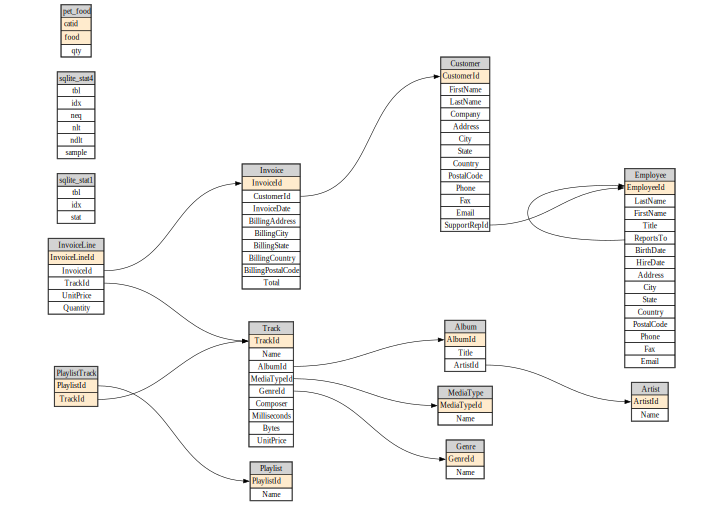

In [ ]:
diagram(db.tables)

## export -

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()